# More features

In [1]:
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

from oemof.solph import (Sink, Source, Transformer, Bus, Flow, Model,
                         EnergySystem, Investment, NonConvex)
import oemof.outputlib as outputlib
import oemof.solph as solph
import oemof.graph as graph
from oemof.tools import economics

import pyomo.environ as po

solver = 'cbc'

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [8.0, 6.0]

In [2]:
color_dict ={
             'coal': '#755d5d',
             'gas': '#c76c56',
             'oil': '#494a19',
             'lignite': '#56201d',
             'wind': '#4ca7c3',
             'pv': '#ffde32',
             'excess_el': '#9a9da1',
             'pp_coal': '#755d5d',
             'pp_gas': '#c76c56',
             'pp_chp': '#eeac7e',
             'b_heat_source': '#cd3333',
             'heat_source': '#cd3333',
             'heat_pump': '#42c77a',
             'electricity': '#0079ff',
             'demand_el': '#0079ff',
             'shortage_el': '#ff2626',
             'excess_el': '#ff2626',
             'biomass': '#01b42e',
             'pp_biomass': '#01b42e'}

In [3]:
def draw_graph(energysystem, edge_labels=True, node_color='#eeac7e',
               edge_color='#eeac7e', plot=True, node_size=5500,
               with_labels=True, arrows=True, layout='dot'):
    
    grph = graph.create_nx_graph(energysystem)
    
    if type(node_color) is dict:
        node_color = [node_color.get(g, '#AFAFAF') for g in grph.nodes()]

    # set drawing options
    options = {
     'prog': 'dot',
     'with_labels': with_labels,
     'node_color': node_color,
     'edge_color': edge_color,
     'node_size': node_size,
     'arrows': arrows,
     'font_size': 12,
     'font_color': 'w'
    }

    # draw graph
    pos = nx.drawing.nx_agraph.graphviz_layout(grph, prog=layout)

    nx.draw(grph, pos=pos, **options)

    # add edge labels for all edges
    if edge_labels is True and plt:
        labels = nx.get_edge_attributes(grph, 'weight')
        nx.draw_networkx_edge_labels(grph, pos=pos, edge_labels=labels)

    # show output
    if plot is True:
        plt.show()

def initialize_basic_energysystem():
    # initialize and provide data
    datetimeindex = pd.date_range('1/1/2016', periods=240, freq='H')
    filename = 'input_data.csv'
    data = pd.read_csv(filename, sep=',')
    energysystem = EnergySystem(timeindex=datetimeindex)

    # buses
    bcoal = Bus(label='coal', balanced=False)
    bgas = Bus(label='gas', balanced=False)
    bel = Bus(label='electricity')
    energysystem.add(bcoal, bgas, bel)

    # sources
    energysystem.add(Source(label='wind', outputs={bel: Flow(
        actual_value=data['wind'], nominal_value=66.3, fixed=True)}))

    energysystem.add(Source(label='pv', outputs={bel: Flow(
        actual_value=data['pv'], nominal_value=65.3, fixed=True)}))

    # excess and shortage to avoid infeasibilies
    energysystem.add(Sink(label='excess_el', inputs={bel: Flow()}))
    energysystem.add(Source(label='shortage_el',
                         outputs={bel: Flow(variable_costs=100000)}))

    # demands (electricity/heat)
    energysystem.add(Sink(label='demand_el', inputs={bel: Flow(
        nominal_value=85, actual_value=data['demand_el'], fixed=True)}))
    
    return bcoal, bgas, bel, energysystem


def postprocess_and_plot(optimization_model):
    results = outputlib.processing.results(optimization_model)

    results_el = outputlib.views.node(results, 'electricity')

    el_sequences = results_el['sequences']

    to_el = {key[0][0]: key for key in el_sequences.keys() if key[0][1] == 'electricity' and key[1] == 'flow'}
    to_el = [to_el.pop('pv'), to_el.pop('wind')] + list(to_el.values())
    el_prod = el_sequences[to_el]

    fig, ax = plt.subplots(figsize=(14, 6))
    for key in el_sequences.keys():
        color_dict[key] = color_dict[key[0][0]]
    c=[color_dict.get(x, '#333333') for x in el_prod.columns]
    el_prod.plot.area(ax=ax, color=c)
    el_sequences[(('electricity', 'demand_el'), 'flow')].plot(ax=ax, linewidth=3, c='k')
    legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot

# Begin by adding two powerplants

In [4]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()

In [5]:
# power plants
energysystem.add(Transformer(
    label='pp_coal',
    inputs={bcoal: Flow()},
    outputs={bel: Flow(nominal_value=20.2, variable_costs=25)},
    conversion_factors={bel: 0.39}))

energysystem.add(Transformer(
    label='pp_gas',
    inputs={bgas: Flow()},
    outputs={bel: Flow(nominal_value=41, variable_costs=40)},
    conversion_factors={bel: 0.50}))

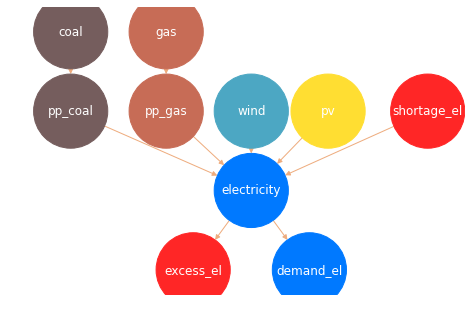

In [6]:
draw_graph(energysystem, node_color=color_dict)

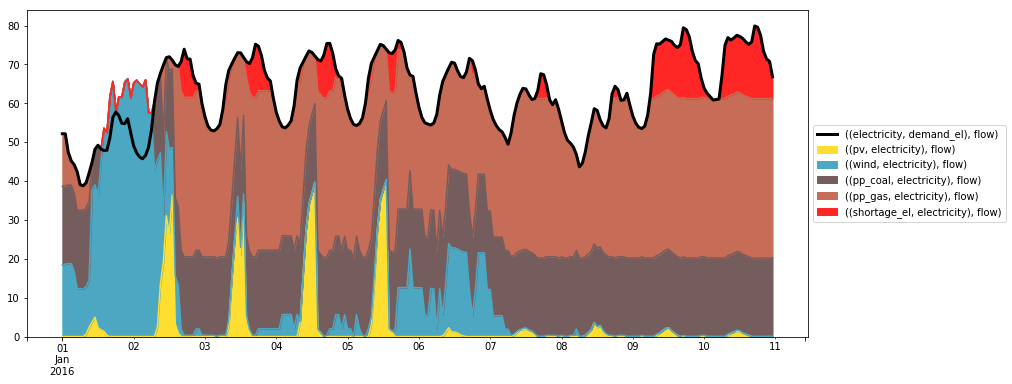

In [7]:
# create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)

# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})

postprocess_and_plot(optimization_model)

# Investment

In [8]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()

In [9]:
# power plants
energysystem.add(Transformer(
    label='pp_coal',
    inputs={bcoal: Flow()},
    outputs={bel: Flow(nominal_value=20.2, variable_costs=25)},
    conversion_factors={bel: 0.39}))

energysystem.add(Transformer(
    label='pp_gas',
    inputs={bgas: Flow()},
    outputs={bel: Flow(nominal_value=41, variable_costs=40)},
    conversion_factors={bel: 0.50}))

epc = economics.annuity(capex=10000, n=20, wacc=0.05)

bbio = Bus(label='biomass', balanced=False)
energysystem.add(bbio)

energysystem.add(Transformer(
    label='pp_biomass',
    inputs={bbio: Flow()},
    outputs={bel: Flow(investment=Investment(ep_costs=epc,
                                             maximum=15,
                                             existing=2),
                       variable_costs=25)},
    conversion_factors={bel: 0.39}))

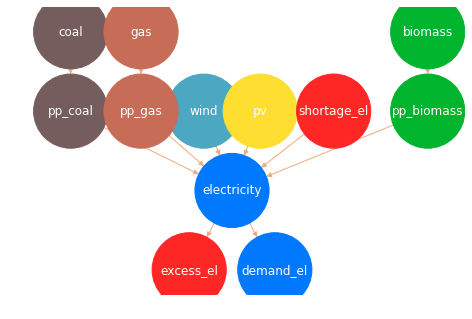

In [10]:
draw_graph(energysystem, node_color=color_dict)

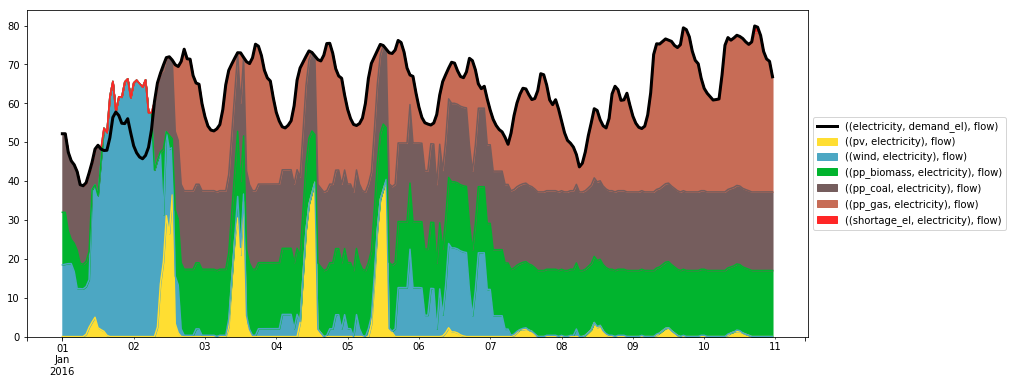

In [11]:
# create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)

# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})

postprocess_and_plot(optimization_model)

### Class Nonconvex: Minimum load

In [12]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()

In [13]:
energysystem.add(solph.Transformer(
    label='pp_gas',
    inputs={bgas: Flow()},
    outputs={bel: Flow(nominal_value=80,
                       nonconvex=NonConvex(),
                       min=0.5)},
    conversion_factors={bel: 0.3}))

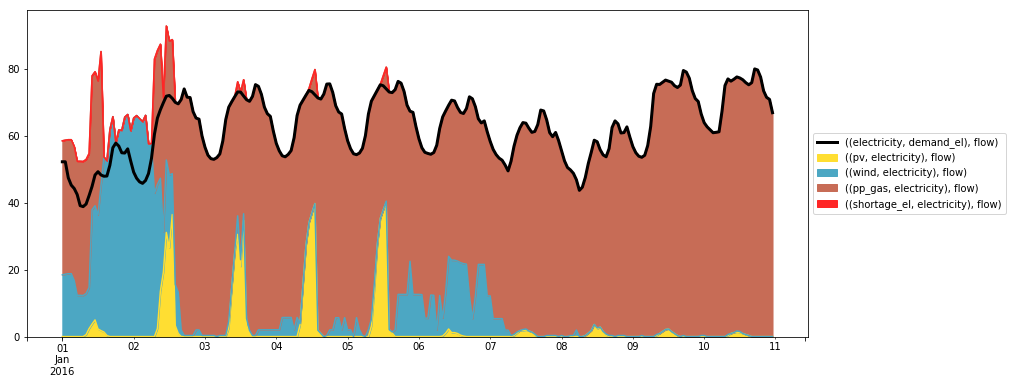

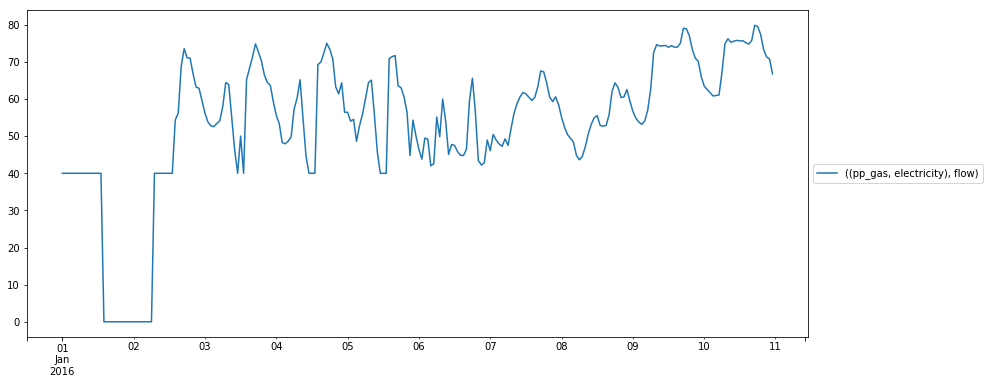

In [14]:
# create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)

# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False}, cmdline_options={'AllowableGap': 0.01})

postprocess_and_plot(optimization_model)

results = outputlib.processing.convert_keys_to_strings(outputlib.processing.results(optimization_model))

fig2, ax2 = plt.subplots(figsize=(14, 6))
results[('pp_gas','electricity')]['sequences']['flow'].plot(ax=ax2, label=(('pp_gas','electricity'),'flow'))
legend = ax2.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot

# Startup costs

pp1 and pp2 are competing to serve overall 12 units load at lowest cost
summed costs for pp1 = 12 * 10 * 10.25 = 1230
summed costs for pp2 = 4*5 + 4*5 + 12 * 10 * 10 = 1240
=> pp1 serves the load despite of higher variable costs since
   the start and shutdown costs of pp2 change its marginal costs

In [15]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()

In [16]:
energysystem.add(Source(
    label='pp_coal',
    outputs={bel: solph.Flow(nominal_value=10, variable_costs=10.25)}))

# shutdown costs only work in combination with a minimum load
# since otherwise the status variable is "allowed" to be active i.e.
# it permanently has a value of one which does not allow to set the shutdown
# variable which is set to one if the status variable changes from one to zero
energysystem.add(Source(
    label='pp_gas',
    outputs={
        bel: solph.Flow(
            nominal_value=10, min=0.5, max=1.0, variable_costs=10,
            nonconvex=solph.NonConvex(startup_costs=5, shutdown_costs=5))}))

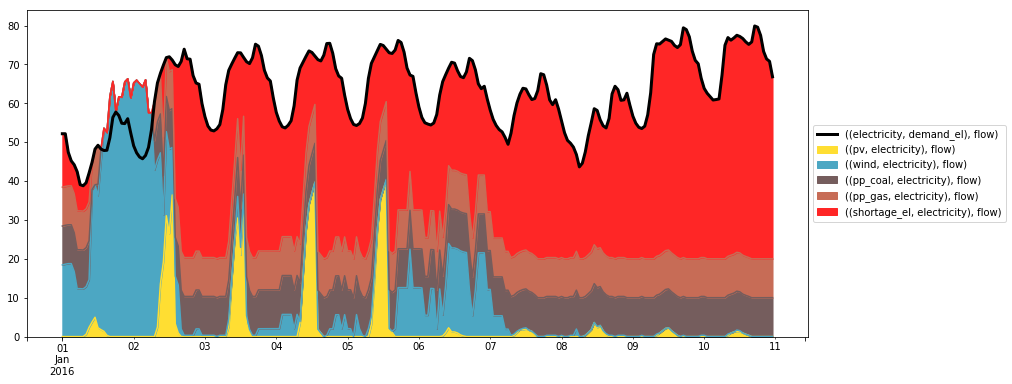

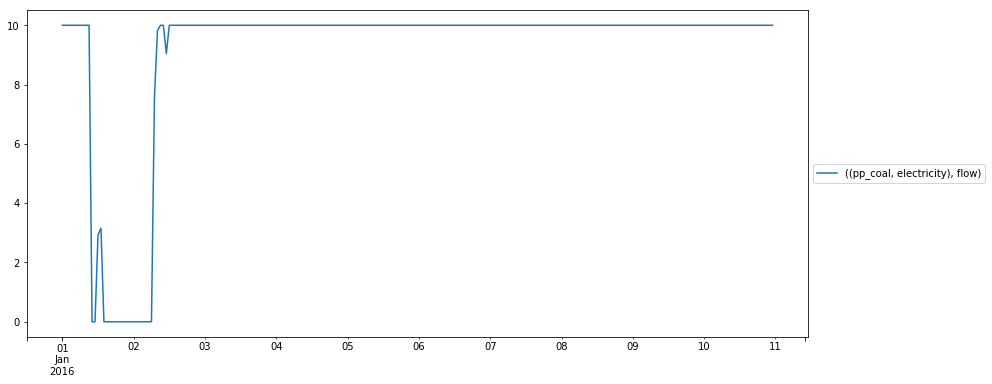

In [17]:
# create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)

# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})

postprocess_and_plot(optimization_model)

results = outputlib.processing.convert_keys_to_strings(outputlib.processing.results(optimization_model))

fig2, ax2 = plt.subplots(figsize=(14, 6))
results[('pp_coal','electricity')]['sequences']['flow'].plot(ax=ax2, label=(('pp_coal','electricity'),'flow'))
legend = ax2.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot

# Minimum up and down times

In [18]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()

In [19]:
energysystem.add(Source(
    label='pp_coal',
    outputs={
        bel: solph.Flow(
            nominal_value=10, min=0.5, max=1.0, variable_costs=10,
            nonconvex=solph.NonConvex(
                minimum_downtime=4, initial_status=0))}))

energysystem.add(Source(
    label='pp_gas',
    outputs={
        bel: solph.Flow(
            nominal_value=10, min=0.5, max=1.0, variable_costs=10,
            nonconvex=solph.NonConvex(
                minimum_uptime=2, initial_status=1))}))

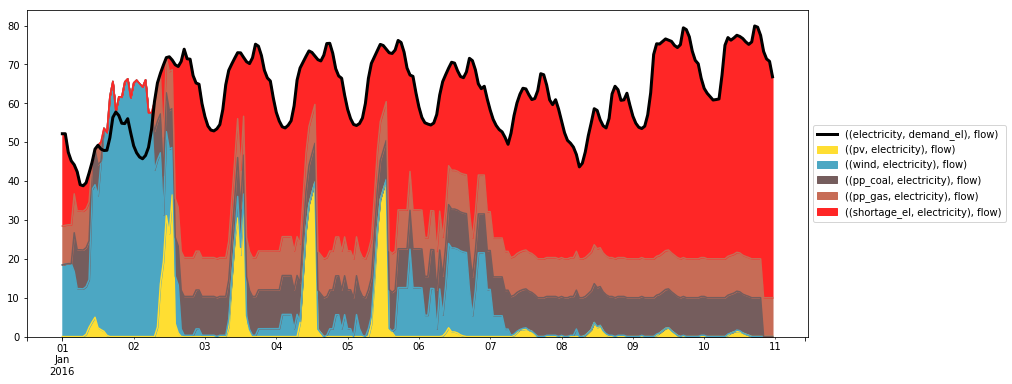

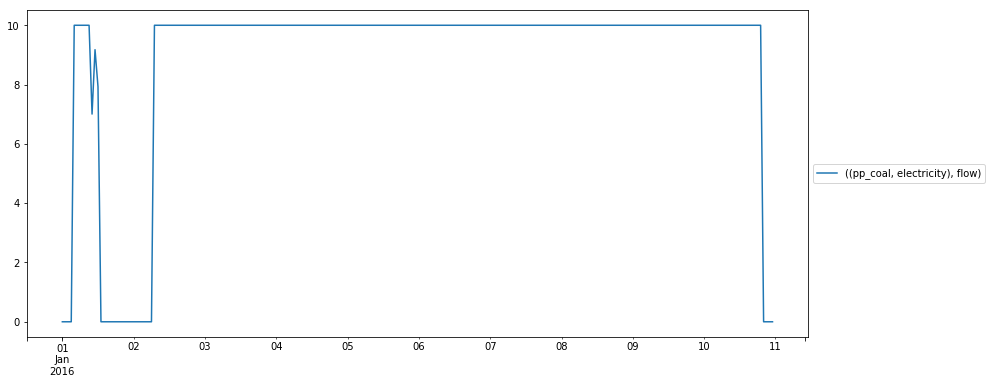

In [20]:
# create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)

# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})

postprocess_and_plot(optimization_model)

results = outputlib.processing.convert_keys_to_strings(outputlib.processing.results(optimization_model))

fig2, ax2 = plt.subplots(figsize=(14, 6))
results[('pp_coal','electricity')]['sequences']['flow'].plot(ax=ax2, label=(('pp_coal','electricity'),'flow'))
legend = ax2.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot

# Additional constraints

* emission constraints

In [21]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()

# power plants
energysystem.add(Transformer(
    label='pp_coal',
    inputs={bcoal: Flow()},
    outputs={bel: Flow(nominal_value=20.2, variable_costs=25)},
    conversion_factors={bel: 0.39}))

pp_gas = Transformer(
    label='pp_gas',
    inputs={bgas: Flow()},
    outputs={bel: Flow(nominal_value=41, variable_costs=40)},
    conversion_factors={bel: 0.50})
energysystem.add(pp_gas)

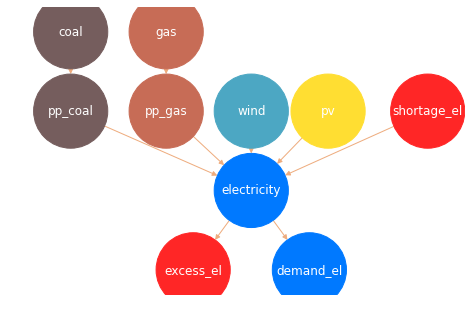

In [22]:
draw_graph(energysystem, node_color=color_dict)

In [50]:
# create the model
optimization_model = Model(energysystem)

emission_limit = 8000
emission_factor = {}
emission_factor['gas'] = 0.27 # t/MWh
emission_factor['coal'] = 0.39 # t/MWh

# add specific emission values to flow objects if source is a commodity bus
for s, t in optimization_model.flows.keys():
    if s is bgas:
        optimization_model.flows[s, t].emission_factor = emission_factor['gas']
    if s is bcoal:
        optimization_model.flows[s, t].emission_factor = emission_factor['coal']

# Add a new pyomo Block
myblock = po.Block()

# pyomo does not need a po.Set, we can use a simple list as well
myblock.COMMODITYFLOWS = [k for (k, v) in optimization_model.flows.items()
                          if hasattr(v, 'emission_factor')]

# add emission constraint
myblock.emission_constr = po.Constraint(expr=(
        sum(optimization_model.flow[i, o, t] *
            optimization_model.flows[i, o].emission_factor
            for (i, o) in myblock.COMMODITYFLOWS
            for t in optimization_model.TIMESTEPS) <= emission_limit))

# add the sub-model to the oemof Model instance
optimization_model.add_component('MyBlock', myblock)

Emissions:  {'coal': 2784.4507199613, 'gas': 5215.5492646679995}
Total emissions:  7999.999984629299


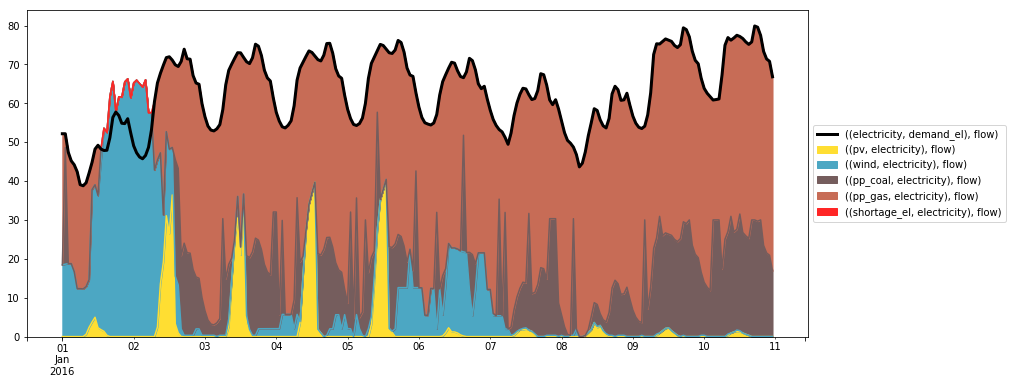

In [51]:
# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})

postprocess_and_plot(optimization_model)

results = outputlib.processing.convert_keys_to_strings(outputlib.processing.results(optimization_model))
emissions = {k[0]: v['sequences']['flow'].sum() * emission_factor[k[0]] for k, v in results.items() if (k[0] == 'gas') or (k[0] == 'coal')}

print('Emissions: ', emissions)
print('Total emissions: ', sum(emissions.values()))

In [25]:
myblock.display()

Block MyBlock

  Variables:
    None

  Objectives:
    None

  Constraints:
    emission_constr : Size=1
        Key  : Lower : Body   : Upper
        None :  None : 1200.0 : 1200.0


In [26]:
for v in optimization_model.component_objects(po.Constraint, descend_into=True):
    print("FOUND VAR:" + v.name)
    print('\n    ')
    v.pprint()
    print('\n    ')

FOUND VAR:Bus.balance

    
balance : Size=240, Index=Bus.balance_index, Active=True
    Key                                                       : Lower : Body                                                                                                                                                                                                                         : Upper : Active
      (<oemof.solph.network.Bus object at 0x7fc5cca0a7c8>, 0) :   0.0 :               flow[wind,electricity,0] + flow[shortage_el,electricity,0] + flow[pp_coal,electricity,0] + flow[pv,electricity,0] + flow[pp_gas,electricity,0] - flow[electricity,excess_el,0] - flow[electricity,demand_el,0] :   0.0 :   True
      (<oemof.solph.network.Bus object at 0x7fc5cca0a7c8>, 1) :   0.0 :               flow[wind,electricity,1] + flow[shortage_el,electricity,1] + flow[pp_coal,electricity,1] + flow[pv,electricity,1] + flow[pp_gas,electricity,1] - flow[electricity,excess_el,1] - flow[electricity,demand_el,1] : 

    Key                                                                                                                                                                       : Lower : Body                                                                     : Upper : Active
      (<oemof.solph.network.Transformer object at 0x7fc5cd4af318>, <oemof.solph.network.Bus object at 0x7fc5cc9c8a98>, <oemof.solph.network.Bus object at 0x7fc5cca0a7c8>, 0) :   0.0 :     flow[coal,pp_coal,0] - 2.564102564102564*flow[pp_coal,electricity,0] :   0.0 :   True
      (<oemof.solph.network.Transformer object at 0x7fc5cd4af318>, <oemof.solph.network.Bus object at 0x7fc5cc9c8a98>, <oemof.solph.network.Bus object at 0x7fc5cca0a7c8>, 1) :   0.0 :     flow[coal,pp_coal,1] - 2.564102564102564*flow[pp_coal,electricity,1] :   0.0 :   True
      (<oemof.solph.network.Transformer object at 0x7fc5cd4af318>, <oemof.solph.network.Bus object at 0x7fc5cc9c8a98>, <oemof.solph.network.Bus object at 0x7fc5cca0a7c8>, 2) :   

    Key  : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

overall investment constraint

new capacity: 
  pp_coal 30.0
  pp_gas 9.9244207

annualized costs :
  pp_coal 24072.776157207387
  pp_gas 15927.223866737031
  sum:  40000.00002394442


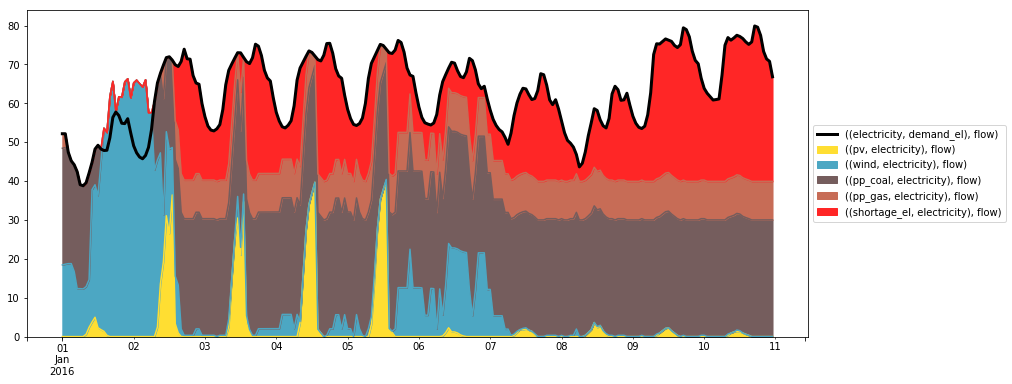

In [27]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()


epc_c = economics.annuity(capex=10000, n=20, wacc=0.05)
epc_g = economics.annuity(capex=20000, n=20, wacc=0.05)

# power plants
energysystem.add(Transformer(
    label='pp_coal',
    inputs={bcoal: Flow()},
    outputs={bel: Flow(investment=solph.Investment(ep_costs=epc_c, maximum=30),
                       variable_costs=25)},
    conversion_factors={bel: 0.39}))

pp_gas = Transformer(
    label='pp_gas',
    inputs={bgas: Flow()},
    outputs={bel: Flow(investment=solph.Investment(ep_costs=epc_g),
                        variable_costs=40)},
    conversion_factors={bel: 0.50})
energysystem.add(pp_gas)

# create the model
optimization_model = Model(energysystem)

solph.constraints.investment_limit(optimization_model, 40000)

# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})

postprocess_and_plot(optimization_model)

results = outputlib.processing.convert_keys_to_strings(outputlib.processing.results(optimization_model))
new_capacity = {k[0]: v['scalars'][0] for k, v in results.items() if (k[0] == 'pp_gas') or (k[0] == 'pp_coal')}

costs = {}
costs['pp_coal'] = new_capacity['pp_coal'] * epc_c
costs['pp_gas'] = new_capacity['pp_gas'] * epc_g
print('new capacity: ')
for k, v in new_capacity.items():
    print(' ', k, v)
print('\nannualized costs :')
for k, v in costs.items():
    print(' ', k, v)
print('  sum: ', sum(costs.values()))